# Курсовой проект курса "Введение в нейронные сети"

**Задача:** 

Требуется, на основании имеющихся данных, произвести детектирование объектов.

**Описание источников данных:**  
https://www.kaggle.com/mbkinaci/fruit-images-for-object-detection

train_zip - данные для обучения модели: состоят из 240 изображений фруктов и описаниям к ним   
test_zip - тестовые данные: состоят из 60 изображений фруктов и описаниям к ним

**План проекта**
- [1. Знакомство с данными](#1)
- [2. Предобработка данных](#2)
- [3. Эксперименты с моделями](#3)
- [4. Валидация модели](#4)
- [5. Выводы по проекту](#5)

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from pathlib import Path

from imageai.Detection import ObjectDetection
from imageai.Detection.Custom import DetectionModelTrainer
from imageai.Detection.Custom import CustomObjectDetection

from PIL import Image

import albumentations as A
import cv2

import xml.etree.ElementTree as ET

In [57]:
train_path = '../data/Fruit Images for Object Detection/train/'
test_path = '../data/Fruit Images for Object Detection/test/'

annots_train_path = sorted([i for i in Path(train_path).glob('*.xml')])
images_train_path = sorted([i for i in Path(train_path).glob('*.jpg')])

annots_test_path = sorted([i for i in Path(test_path).glob('*.xml')])
images_test_path = sorted([i for i in Path(test_path).glob('*.jpg')])

n_imgs = len(images_train_path)
print(f'train - {n_imgs}, test -{len(images_test_path)}')

train - 240, test -60


# 1. Знакомство с данными <a class='anchor' id=1>

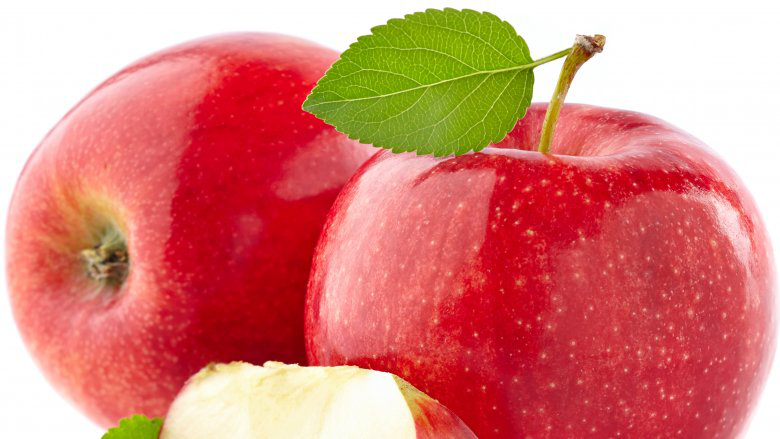

In [58]:
Image.open('../data/Fruit Images for Object Detection/train/apple_31.jpg')

In [59]:
with open(annots_train_path[24], 'r') as f:
    print(f.read())

<annotation>
	<folder>train</folder>
	<filename>apple_31.jpg</filename>
	<path>C:\tensorflow1\models\research\object_detection\images\train\apple_31.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>780</width>
		<height>439</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>304</xmin>
			<ymin>105</ymin>
			<xmax>773</xmax>
			<ymax>439</ymax>
		</bndbox>
	</object>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>3</xmin>
			<ymin>40</ymin>
			<xmax>475</xmax>
			<ymax>439</ymax>
		</bndbox>
	</object>
</annotation>



# 2. Предобработка данных <a class='anchor' id=2>

In [60]:
#Функция  исправления нулевых значений width и height в аннотациях
def editXML(file):
    
    my_file = open(file, 'r')
    string = my_file.read()
    
    width = string[string.find('<width>')+len('<width>') : string.find('</width>')]
    height = string[string.find('<height>')+len('<height>') : string.find('</height>')]
    
    if width == '0' or height == '0':
        
        folder = string[string.find('<folder>')+len('<folder>') : string.find('</folder>')]
        filename = string[string.find('<filename>')+len('<filename>') : string.find('</filename>')]
        path_img = f'../data/Fruit Images for Object Detection/{folder}/{filename}'
        
        im = Image.open(path_img)
        (width_im, height_im) = im.size

        tree = ET.parse(file)
        root = tree.getroot()

        for elem in root.iter("width"):
            elem.text = str(width_im)

        for elem in root.iter("height"):
            elem.text = str(height_im)

        tree.write('../data/Fruit Images for Object Detection/newfile.xml')

        return '../data/Fruit Images for Object Detection/newfile.xml'
    
    else:
        return file

In [61]:
# Функция аугментации изображений и аннотаций
def augmentation_image_and_XML(file):

    my_file = open(file, 'r')
    string = my_file.read()

    path_image = file.replace('annotations', 'images')
    image = cv2.imread(path_image[:-3]+'jpg')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    bboxes = []
    class_labels = []
    
    for item in string.split('</object>'):
        if '<object>' in item:
            bboxes.append([int(item[item.find('<xmin>')+len('<xmin>') : item.find('</xmin>')]),
                           int(item[item.find('<ymin>')+len('<ymin>') : item.find('</ymin>')]),
                           int(item[item.find('<xmax>')+len('<xmax>') : item.find('</xmax>')]),
                           int(item[item.find('<ymax>')+len('<ymax>') : item.find('</ymax>')])])
            class_labels.append(item[item.find('<name>')+len('<name>') : item.find('</name>')])

    transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomBrightnessContrast(p=0.2),
    A.ChannelDropout(channel_drop_range=(1, 1), fill_value=0, p=0.1),
    ], bbox_params=A.BboxParams(format='pascal_voc', min_area=1024, min_visibility=0.1, label_fields=['class_labels']))
    
    for i in range(1, 5):
        transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
        transformed_image = transformed['image']
        transformed_bboxes = transformed['bboxes']
        transformed_class_labels = transformed['class_labels']

        # сохранить изображение
        Image.fromarray(transformed_image).save(f'{path_image[:-4]}-{i}.jpg',quality=95)
        
        # сохранить аннотацию 
        folder = string[string.find('<folder>')+len('<folder>') : string.find('</folder>')]
        filename = string[string.find('<filename>')+len('<filename>') : string.find('</filename>')]
        width = string[string.find('<width>')+len('<width>') : string.find('</width>')]
        height = string[string.find('<height>')+len('<height>') : string.find('</height>')]
        
        annotation = ET.Element("annotation")
        ET.SubElement(annotation, "folder").text = folder
        ET.SubElement(annotation, "filename").text = str(f'{filename[:-4]}-{i}.jpg')
        ET.SubElement(annotation, "path").text = str(f'{path_image[:-4]}-{i}.jpg')
        source = ET.SubElement(annotation, "source")
        ET.SubElement(source, "database").text = "Unknown"
        size = ET.SubElement(annotation, "size")
        ET.SubElement(size, "width").text = str(width)
        ET.SubElement(size, "height").text = str(height)
        ET.SubElement(size, "depth").text = "3"
        ET.SubElement(annotation, "segmented").text = "0"
        for num, box in enumerate(transformed_bboxes):
            object = ET.SubElement(annotation, "object")
            ET.SubElement(object, "name").text = transformed_class_labels[num]
            ET.SubElement(object, "pose").text = "Unspecified"
            ET.SubElement(object, "truncated").text = "0"
            ET.SubElement(object, "difficult").text = "0"
            bndbox = ET.SubElement(object, "bndbox")
            ET.SubElement(bndbox, "xmin").text = str(int(box[0])) 
            ET.SubElement(bndbox, "ymin").text = str(int(box[1]))
            ET.SubElement(bndbox, "xmax").text = str(int(box[2]))
            ET.SubElement(bndbox, "ymax").text = str(int(box[3]))

        tree = ET.ElementTree(annotation)
        tree.write(f'{file[:-4]}-{i}.xml')

In [62]:
# создание директорий для сохранение предобработанных данных
os.makedirs('../data/Fruit Images for Object Detection/imageai/train/images', exist_ok=True)
os.makedirs('../data/Fruit Images for Object Detection/imageai/train/annotations', exist_ok=True)

os.makedirs('../data/Fruit Images for Object Detection/imageai/validation/images', exist_ok=True)
os.makedirs('../data/Fruit Images for Object Detection/imageai/validation/annotations', exist_ok=True)

os.makedirs('../data/Fruit Images for Object Detection/imageai/test/images', exist_ok=True)
os.makedirs('../data/Fruit Images for Object Detection/imageai/test/annotations', exist_ok=True)

In [63]:
# формирование списка классов
set_classes = set()
annots_path = annots_train_path + annots_test_path

for annot in annots_path:
    with open(annot, 'r') as f:
        string = f.read()
        name = string[string.find('<name>')+6:string.find('</name>')]
        set_classes.add(name)

classes = np.array(list(set_classes))
print(classes)

['apple' 'orange' 'banana']


In [64]:
# разбиение и сохранение предобработанных данных
for i, (annot_path, img_path) in enumerate(zip(annots_train_path, images_train_path)):   
    if i > n_imgs:
        break
        
    if i%5 == 0:
        new_path = shutil.copy(img_path, '../data/Fruit Images for Object Detection/imageai/validation/images/' + img_path.parts[-1])
        # редактирование валидационных данных
        annot_path_edit = editXML(annot_path)
        annot_path_new = shutil.copy(annot_path_edit, '../data/Fruit Images for Object Detection/imageai/validation/annotations/' + annot_path.parts[-1])
        # аугментация валидационных данных
        augmentation_image_and_XML(annot_path_new)
    else:
        shutil.copy(img_path, '../data/Fruit Images for Object Detection/imageai/train/images/' + img_path.parts[-1])
        # редактирование тренировочных данных
        annot_path_edit = editXML(annot_path)
        annot_path_new = shutil.copy(annot_path_edit, '../data/Fruit Images for Object Detection/imageai/train/annotations/' + annot_path.parts[-1])
        # аугментация тренировочных данных
        augmentation_image_and_XML(annot_path_new)
        
for i, (annot_test_path, img_test_path) in enumerate(zip(annots_test_path, images_test_path)):  
    shutil.copy(img_test_path, '../data/Fruit Images for Object Detection/imageai/test/images/' + img_test_path.parts[-1])
    annot_test_path_new = editXML(annot_test_path)
    shutil.copy(annot_test_path_new, '../data/Fruit Images for Object Detection/imageai/test/annotations/' + annot_test_path.parts[-1])

In [65]:
print(len(list(Path('../data/Fruit Images for Object Detection/imageai/train/annotations/').glob('*.xml'))))
print(len(list(Path('../data/Fruit Images for Object Detection/imageai/validation/annotations/').glob('*.xml'))))
print(len(list(Path('../data/Fruit Images for Object Detection/imageai/test/annotations/').glob('*.xml'))))

960
240
60


# 3. Эксперименты с моделями <a class='anchor' id=3>

In [76]:
# детекирование объекта предобученной YOLOv3 моделью
detector = ObjectDetection()
detector.setModelTypeAsYOLOv3()
detector.setModelPath("../data/Fruit Images for Object Detection/pretrained-yolov3.h5")
detector.loadModel()
detections = detector.detectObjectsFromImage(input_image='../data/Fruit Images for Object Detection/train/apple_31.jpg',
                                             output_image_path='../data/Fruit Images for Object Detection/detected.jpg',
                                             minimum_percentage_probability=50)

for eachObject in detections:
    print(eachObject["name"] , " : ", eachObject["percentage_probability"], " : ", eachObject["box_points"] )
    print("--------------------------------")

apple  :  64.84827995300293  :  [307, 155, 781, 470]
--------------------------------


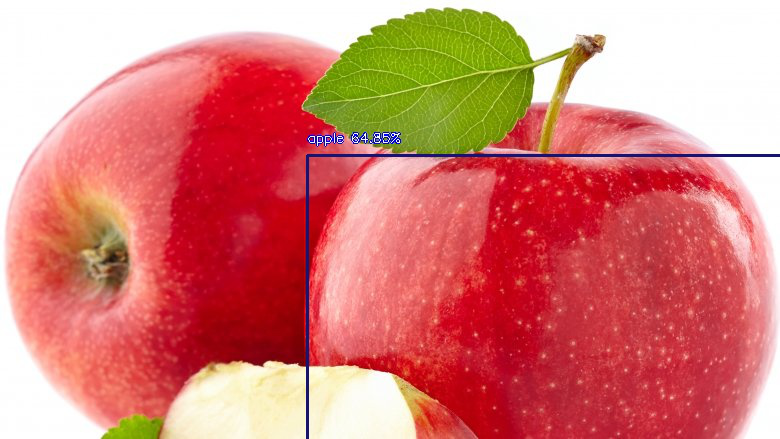

In [77]:
Image.open('../data/Fruit Images for Object Detection/detected.jpg')

In [79]:
# обучение своей модели
trainer = DetectionModelTrainer()
trainer.setModelTypeAsYOLOv3()
trainer.setDataDirectory(data_directory="../data/Fruit Images for Object Detection/imageai")
trainer.setTrainConfig(object_names_array=classes,
                       batch_size=20,
                       num_experiments=1,
                       train_from_pretrained_model="../data/Fruit Images for Object Detection/pretrained-yolov3.h5")

trainer.trainModel()

Generating anchor boxes for training images and annotation...
Average IOU for 9 anchors: 0.80
Anchor Boxes generated.
Detection configuration saved in  ../data/Fruit Images for Object Detection/imageai/json/detection_config.json
Evaluating over 240 samples taken from ../data/Fruit Images for Object Detection/imageai/validation
Training over 960 samples  given at ../data/Fruit Images for Object Detection/imageai/train
Training on: 	['apple', 'banana', 'orange']
Training with Batch Size:  20
Number of Training Samples:  960
Number of Validation Samples:  240
Number of Experiments:  1
Training with transfer learning from pretrained Model
384/384 [==============================] - 3962s 10s/step - loss: 84.7954 - yolo_layer_6_loss: 14.1827 - yolo_layer_7_loss: 17.6731 - yolo_layer_8_loss: 41.4007 - val_loss: 63.1932 - val_yolo_layer_6_loss: 13.6802 - val_yolo_layer_7_loss: 12.8826 - val_yolo_layer_8_loss: 25.1848


# 4. Валидация модели <a class='anchor' id=4>

In [80]:
files = sorted(os.listdir('../data/Fruit Images for Object Detection/imageai/models/'))[-1]

trainer = DetectionModelTrainer()
trainer.setModelTypeAsYOLOv3()
trainer.setDataDirectory(data_directory="../data/Fruit Images for Object Detection/imageai")
metrics = trainer.evaluateModel(model_path=f"../data/Fruit Images for Object Detection/imageai/models/{files}",
                                json_path="../data/Fruit Images for Object Detection/imageai/json/detection_config.json",
                                iou_threshold=0.2,
                                object_threshold=0.3,
                                nms_threshold=0.5)

Starting Model evaluation....
Evaluating over 240 samples taken from ../data/Fruit Images for Object Detection/imageai/validation
Training over 960 samples  given at ../data/Fruit Images for Object Detection/imageai/train
Model File:  ../data/Fruit Images for Object Detection/imageai/models/detection_model-ex-001--loss-0084.795.h5 

Evaluation samples:  240
Using IoU:  0.2
Using Object Threshold:  0.3
Using Non-Maximum Suppression:  0.5
apple: 0.0449
banana: 0.2524
orange: 0.0000
mAP: 0.0991


In [85]:
# детекирование объекта обученой своей моделью
detector = CustomObjectDetection()
detector.setModelTypeAsYOLOv3()
detector.setModelPath(f"../data/Fruit Images for Object Detection/imageai/models/{files}")
detector.setJsonPath("../data/Fruit Images for Object Detection/imageai/json/detection_config.json")
detector.loadModel()
detections = detector.detectObjectsFromImage(minimum_percentage_probability=20,
                                             input_image="../data/Fruit Images for Object Detection/train/apple_31.jpg",
                                             output_image_path="../data/Fruit Images for Object Detection/my_detected.jpg")
for detection in detections:
    print(detection["name"], " : ", detection["percentage_probability"], " : ", detection["box_points"])

apple  :  21.18561863899231  :  [33, 14, 512, 363]


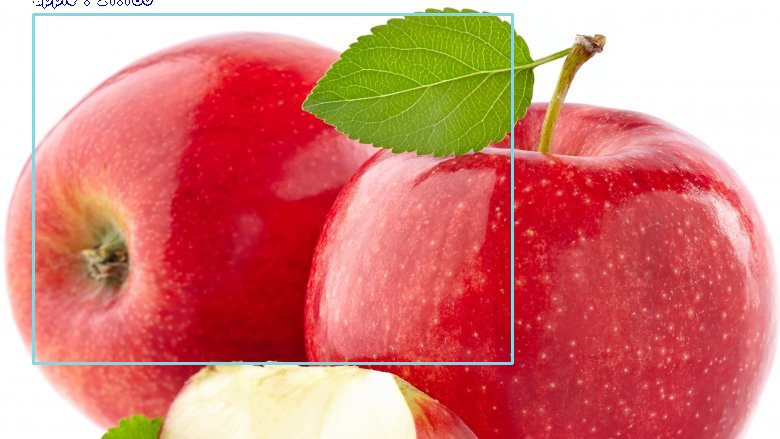

In [86]:
Image.open('../data/Fruit Images for Object Detection/my_detected.jpg')

# 5. Выводы по проекту <a class='anchor' id=5>
    
  Для более качественного детектирования объектов на имеющихся данных необходимо:  
    - увеличить количество аугментированных данных на каждый объект  
    - увеличить количество эпох при обучении модели